In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

C:\Users\yunna\AppData\Local\Temp\ipykernel_26632\930725367.py:5: SADeprecationWarning: The AutomapBase.prepare.reflect parameter is deprecated and will be removed in a future release.  Reflection is enabled when AutomapBase.prepare.autoload_with is passed.
  Base.prepare(engine, reflect=True)


In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
# Find the most recent date in the data set.
latest_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()[0]

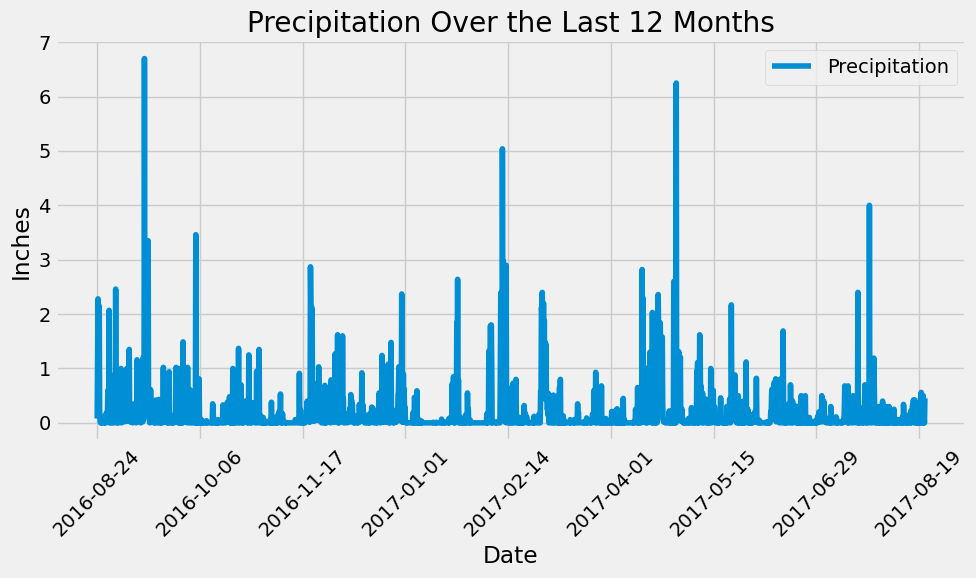

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
one_year_ago = dt.datetime.strptime(latest_date, "%Y-%m-%d") - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
precipitation_data = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= one_year_ago).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
precipitation_df = pd.DataFrame(precipitation_data, columns=['Date', 'Precipitation'])
precipitation_df = precipitation_df.dropna()

# Sort the dataframe by date
precipitation_df = precipitation_df.sort_values(by='Date')

# Use Pandas Plotting with Matplotlib to plot the data
precipitation_df.plot(x='Date', y='Precipitation', figsize=(10,6), title='Precipitation Over the Last 12 Months')
plt.xticks(rotation=45)
plt.ylabel('Inches')
plt.xlabel('Date')
plt.tight_layout()
plt.show()

In [11]:
# Use Pandas to calculate the summary statistics for the precipitation data
precipitation_df.describe()

,Precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [12]:
# Design a query to calculate the total number of stations in the dataset
total_stations = session.query(func.count(Station.station)).scalar()
print(f"Total number of stations: {total_stations}")

Total number of stations: 9


In [13]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
active_stations = session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).all()

# List the stations and their counts in descending order.
active_stations_df = pd.DataFrame(active_stations, columns=['Station', 'Count'])
print(active_stations_df)

       Station  Count
0  USC00519281   2772
1  USC00519397   2724
2  USC00513117   2709
3  USC00519523   2669
4  USC00516128   2612
5  USC00514830   2202
6  USC00511918   1979
7  USC00517948   1372
8  USC00518838    511


In [17]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station = active_stations[0][0]

temperature_stats = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
    filter(Measurement.station == most_active_station).all()

lowest_temp, highest_temp, avg_temp = temperature_stats[0]
print(f"{most_active_station} - {lowest_temp}, {highest_temp}, {avg_temp:.2f}")

USC00519281 - 54.0, 85.0, 71.66


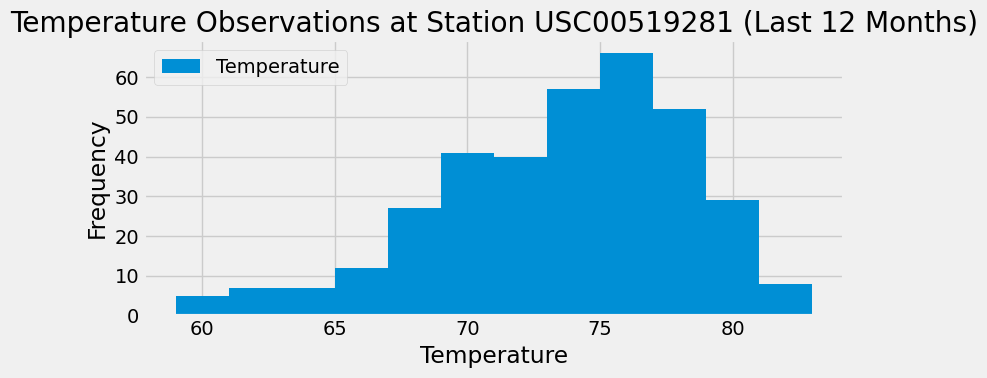

In [20]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temperature_data = session.query(Measurement.tobs).\
    filter(Measurement.station == most_active_station).\
    filter(Measurement.date >= one_year_ago).all()

# Convert the query result into a DataFrame
temperature_df = pd.DataFrame(temperature_data, columns=['Temperature'])

# Plot the results as a histogram
temperature_df.plot(kind='hist', bins=12, figsize=(8,4), title=f'Temperature Observations at Station {most_active_station} (Last 12 Months)')
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

# Close Session

In [21]:
# Close Session
session.close()